<a href="https://colab.research.google.com/github/kamijoseph/Crops-Recomendation-System/blob/main/notebook/crops_recomendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crops Recomendation System

In [6]:
#!pip install -q scikit-learn==1.7.1

In [7]:
#!pip install xgboost shap

## dependencies

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
import shap

In [9]:
from multiprocessing import context
# plot style
sns.set(style="whitegrid", context="notebook")

## dataset

In [10]:
data = pd.read_csv("/content/crops.csv")
data.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [11]:
data.shape

(2200, 8)

In [12]:
# basic data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [13]:
# checking number of labels
labels = data["label"].value_counts()
labels

,count
label,
rice,100
maize,100
chickpea,100
kidneybeans,100
pigeonpeas,100
mothbeans,100
mungbean,100
blackgram,100
lentil,100


In [14]:
len(labels)

22

In [15]:
# basic statistical information
data.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [16]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
N,2200.0,50.551818,36.917334,0.000000,21.000000,37.000000,84.250000,140.000000
P,2200.0,53.362727,32.985883,5.000000,28.000000,51.000000,68.000000,145.000000
K,2200.0,48.149091,50.647931,5.000000,20.000000,32.000000,49.000000,205.000000
temperature,2200.0,25.616244,5.063749,8.825675,22.769375,25.598693,28.561654,43.675493
humidity,2200.0,71.481779,22.263812,14.258040,60.261953,80.473146,89.948771,99.981876
ph,2200.0,6.469480,0.773938,3.504752,5.971693,6.425045,6.923643,9.935091
rainfall,2200.0,103.463655,54.958389,20.211267,64.551686,94.867624,124.267508,298.560117


In [17]:
# checking for missing values
data.isnull().sum()

,0
N,0
P,0
K,0
temperature,0
humidity,0
ph,0
rainfall,0
label,0


In [18]:
# checking for duplicates
data.duplicated().sum()

np.int64(0)

In [19]:
data.shape

(2200, 8)

In [20]:
data.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


## insights:
  - no missing values
  - no duplicates
  - 22 labels equally distributed (100)
  - 7 features (N, P, K, temperature, humididty, ph, rainfall) --> N for nitrogen levels, P for phosphorous, K for potassium contents in the soil.
  - small dataset of 2200 entries

## exploratory data analysis

In [21]:
data[['ph', 'humidity']].nunique()

,0
ph,2200
humidity,2200


In [22]:
data[['ph', 'humidity']].nunique()

,0
ph,2200
humidity,2200


In [23]:
data[['ph', 'humidity']].describe()

,ph,humidity
count,2200.000000,2200.000000
mean,6.469480,71.481779
std,0.773938,22.263812
min,3.504752,14.258040
25%,5.971693,60.261953
50%,6.425045,80.473146
75%,6.923643,89.948771
max,9.935091,99.981876


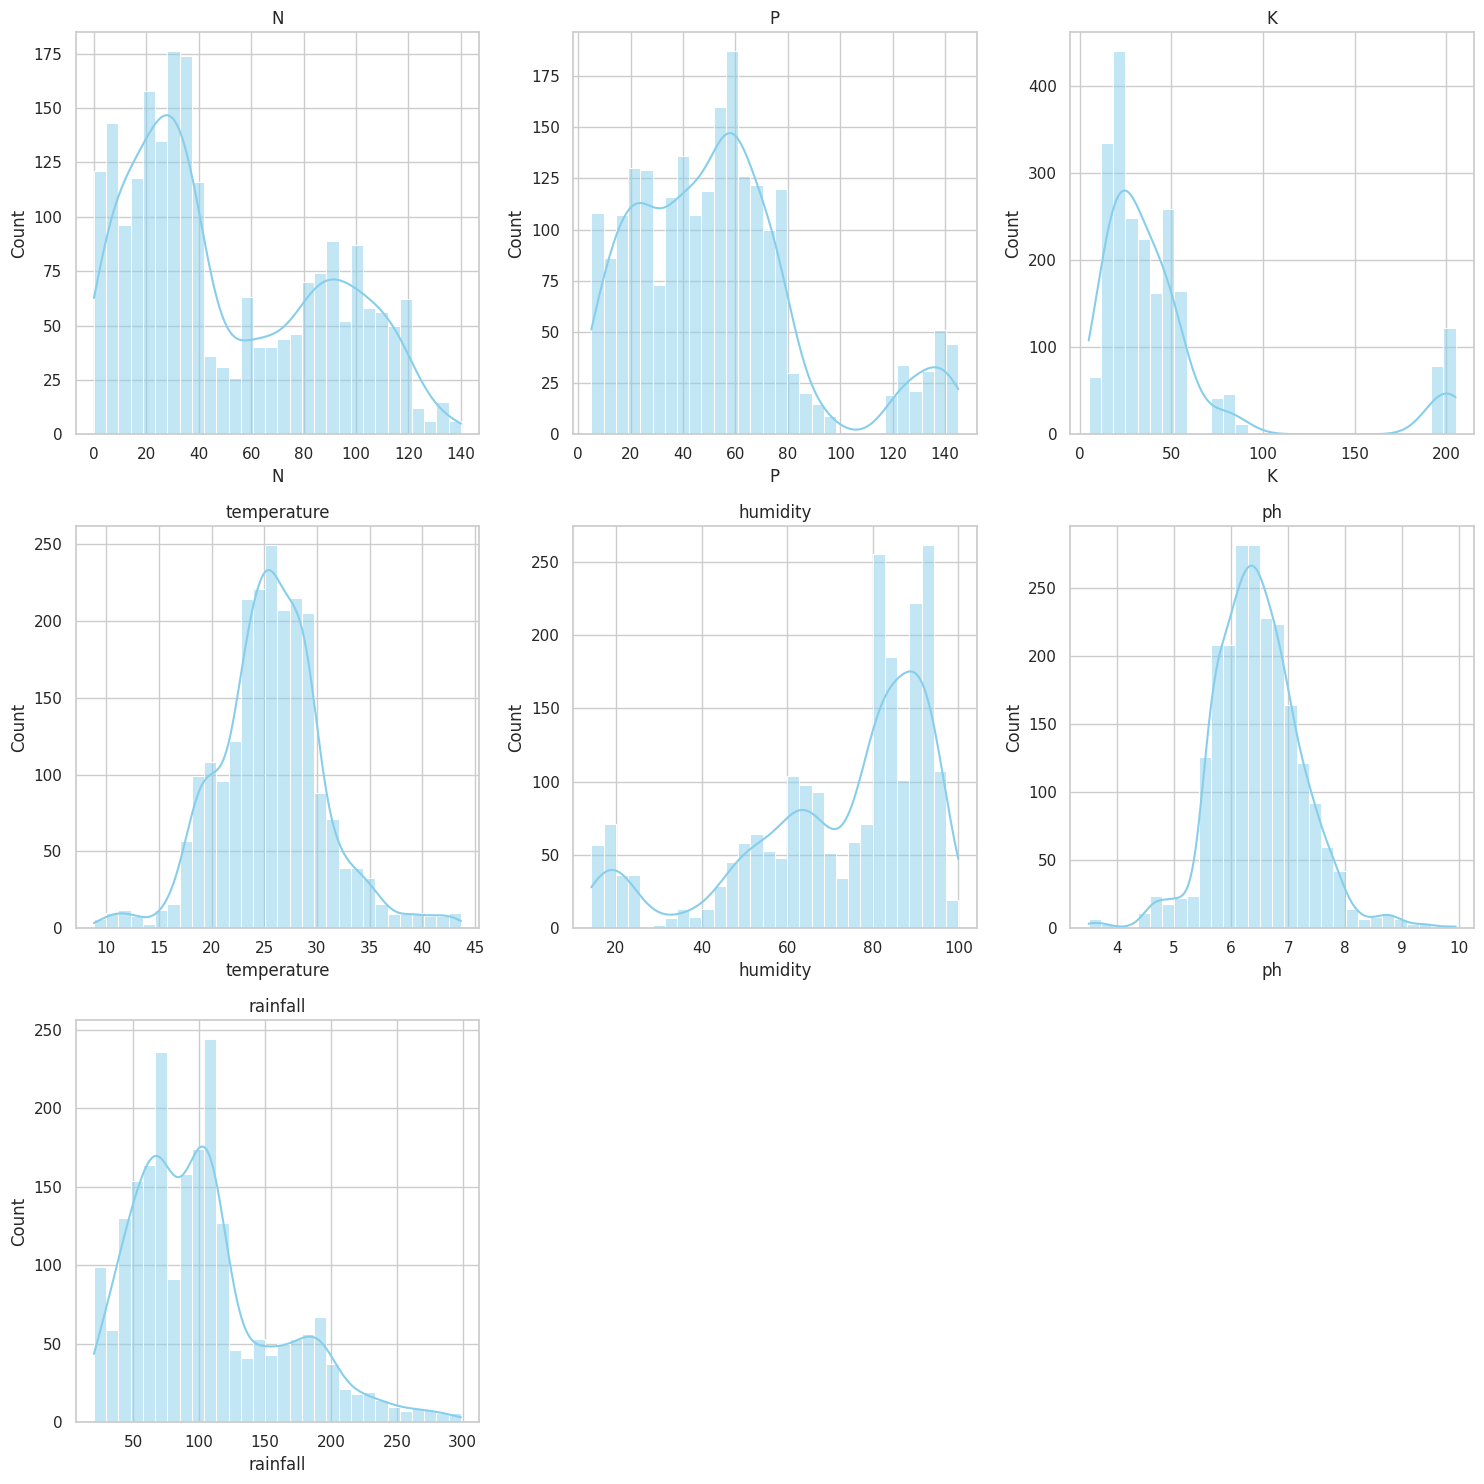

In [24]:
features = data.columns[:-1]
n_features = len(features)
rows = math.ceil(n_features / 3)

fig, axs = plt.subplots(rows, 3, figsize=(15, 5*rows))
axs = axs.flatten()

for i, feature in enumerate(features):
    sns.histplot(
        data[feature],
        ax=axs[i],
        kde=True,
        bins=30,
        color="skyblue"
    )
    axs[i].set_title(feature)

# hide unused subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

<Axes: >

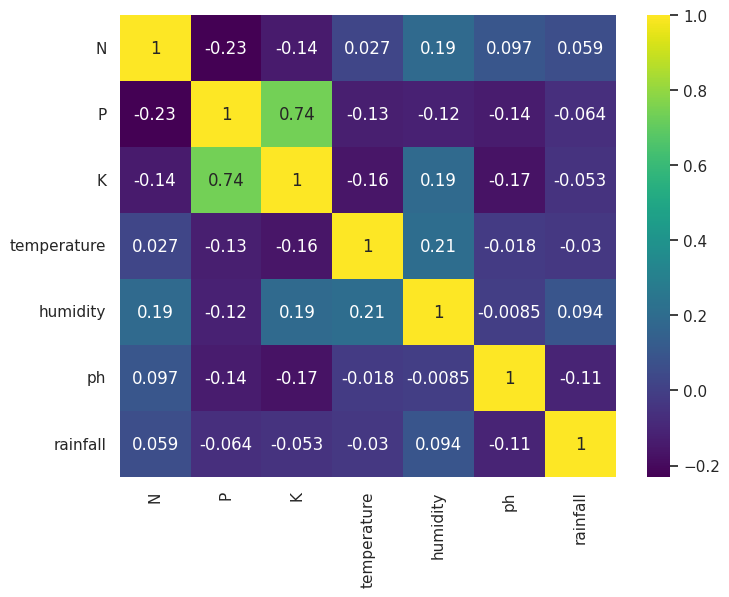

In [25]:
# correlation matrix
corr = data[features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot = True,
    cmap = "viridis"
)

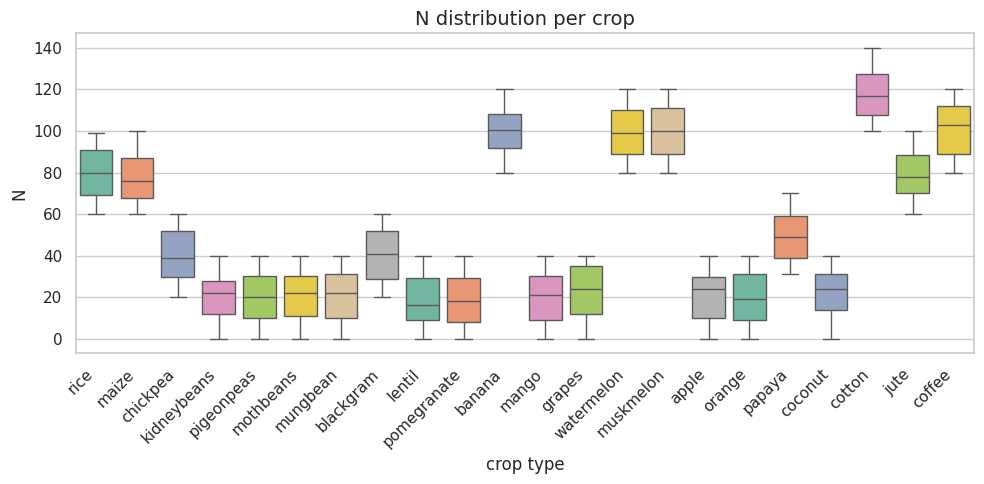

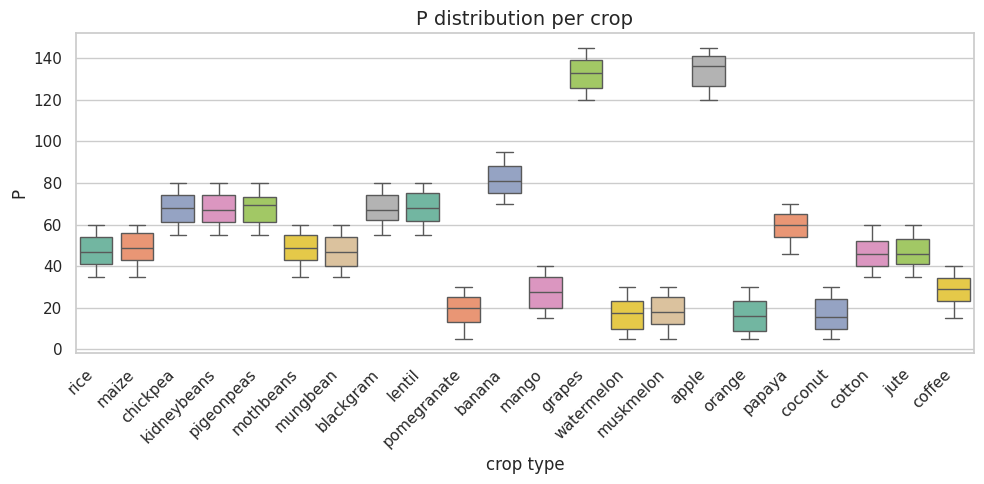

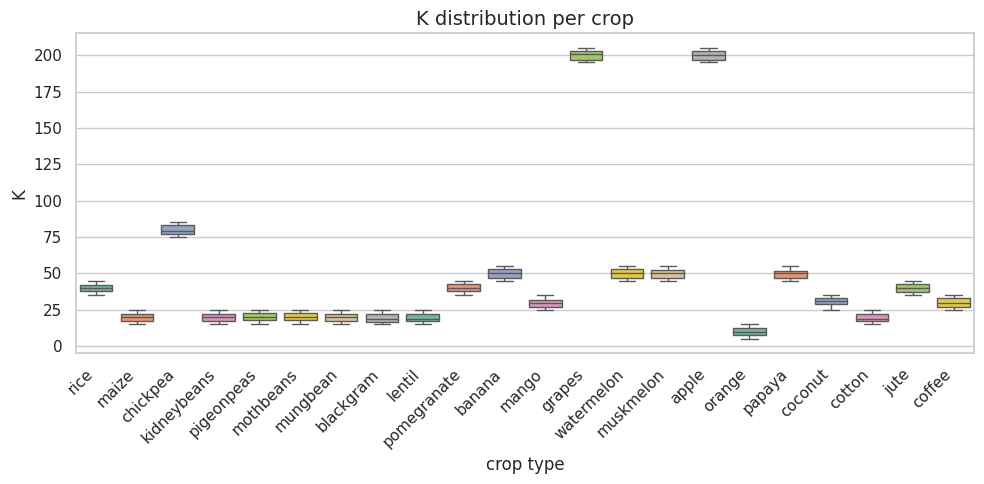

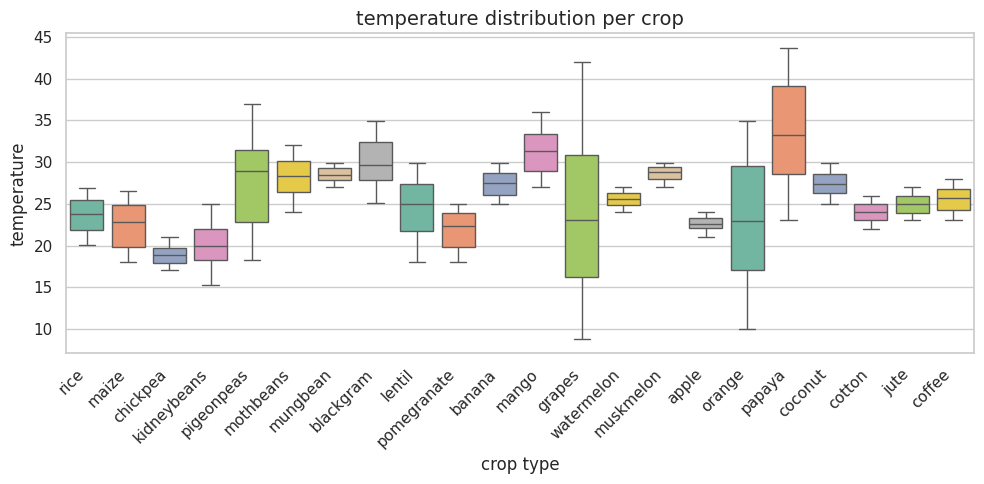

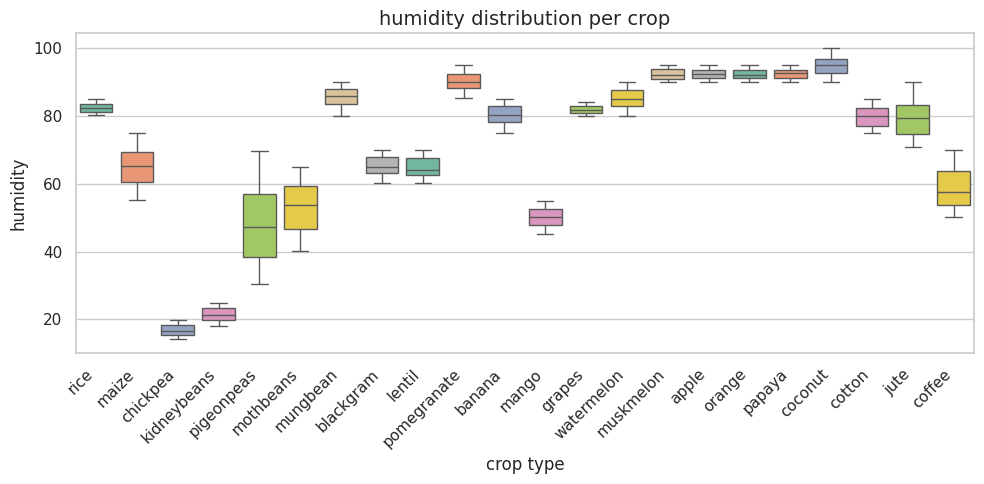

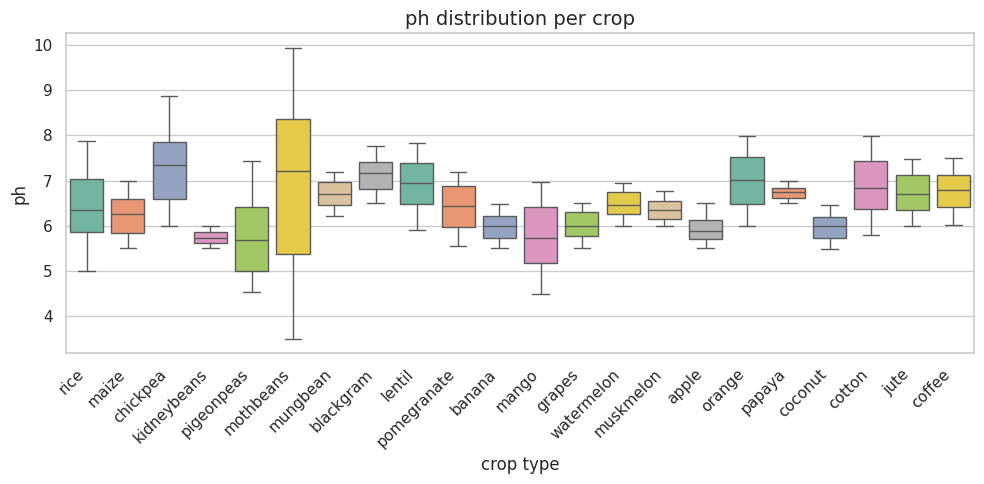

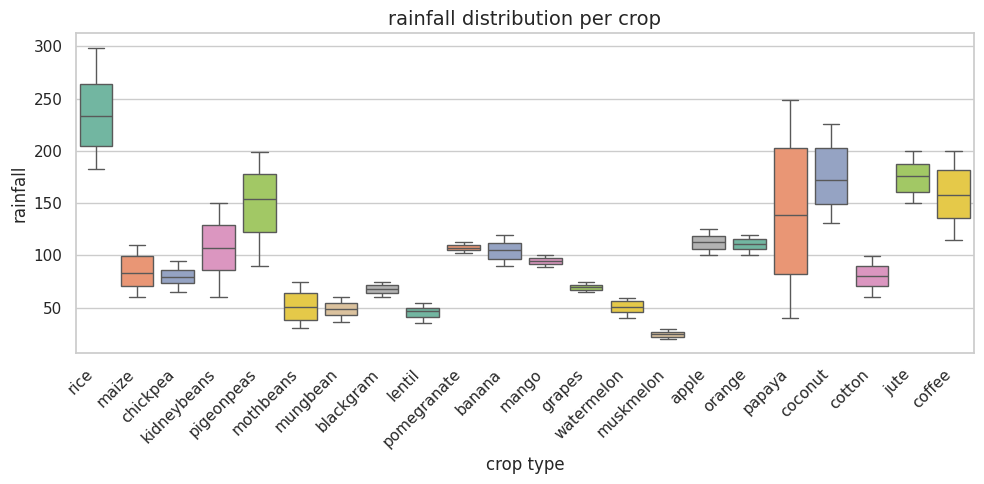

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# crop vs feature relationship
for feature in features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(
        x="label",
        y=feature,
        hue="label",
        data=data,
        palette="Set2",
        legend=False,
        showfliers=False
    )
    plt.xticks(rotation=45, ha='right')
    plt.title(f"{feature} distribution per crop", fontsize=14)
    plt.xlabel("crop type")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()


## preprocessing

In [27]:
# feature and label separation
X, y = data.drop("label", axis=1), data["label"]
X.shape


(2200, 7)

In [28]:
y

,label
0,rice
1,rice
2,rice
3,rice
4,rice
...,...
2195,coffee
2196,coffee
2197,coffee
2198,coffee


In [29]:
# label encoding
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded

array([20, 20, 20, ...,  5,  5,  5])

In [30]:
encoder.classes_

array(['apple', 'banana', 'blackgram', 'chickpea', 'coconut', 'coffee',
       'cotton', 'grapes', 'jute', 'kidneybeans', 'lentil', 'maize',
       'mango', 'mothbeans', 'mungbean', 'muskmelon', 'orange', 'papaya',
       'pigeonpeas', 'pomegranate', 'rice', 'watermelon'], dtype=object)

In [31]:
data.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [32]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size = 0.2,
    random_state = 21,
    stratify = y_encoded
)
print(X.shape, X_train.shape, X_test.shape)

(2200, 7) (1760, 7) (440, 7)


In [33]:
X.head()

,N,P,K,temperature,humidity,ph,rainfall
0,90,42,43,20.879744,82.002744,6.502985,202.935536
1,85,58,41,21.770462,80.319644,7.038096,226.655537
2,60,55,44,23.004459,82.320763,7.840207,263.964248
3,74,35,40,26.491096,80.158363,6.980401,242.864034
4,78,42,42,20.130175,81.604873,7.628473,262.717340


In [34]:
# feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
X_train_scaled

array([[-1.17305137, -1.09933896, -0.43732306, ..., -1.02535663,
        -0.08218275, -0.22037847],
       [-0.36077202,  0.323758  , -0.5163587 , ..., -2.37448768,
        -0.67516062,  0.32995949],
       [ 0.26197547,  0.05125007, -0.16069832, ...,  0.78668622,
         0.70858931,  0.86657114],
       ...,
       [-0.73983572,  0.35403666, -0.55587652, ..., -2.21217726,
        -0.83083238,  0.0835334 ],
       [-1.06474745, -1.31128957, -0.06190377, ...,  0.7640967 ,
        -0.10349899,  0.09565031],
       [-0.27954409, -0.06986456, -0.61515325, ...,  0.65889996,
         0.49301966, -0.97600353]])

In [36]:
X_test_scaled

array([[ 0.45150732, -0.31209383, -0.18045723, ...,  0.60693438,
        -0.61674283,  1.50680105],
       [-0.7669117 , -0.70571639, -0.71394781, ...,  0.94687529,
        -0.16022137,  0.27720996],
       [ 1.69700231, -0.37265115, -0.55587652, ...,  0.40727945,
         1.00400461, -0.13512495],
       ...,
       [-1.36258321, -0.85710969, -0.67442999, ...,  0.9229411 ,
        -0.15033792,  0.23028086],
       [-0.27954409,  0.50542995, -0.55587652, ..., -1.19322746,
        -1.10220166,  0.78563625],
       [ 0.88472297,  0.20264336, -0.23973396, ...,  0.38949449,
         0.54896106,  1.76247858]])

## models and models training

### baseline model --> random forest

In [37]:
# initialization
rf_model = RandomForestClassifier(
    n_estimators = 200,
    random_state = 21
)

In [38]:
# training
rf_model.fit(
    X_train_scaled,
    y_train
)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [39]:
# predictions
rf_pred = rf_model.predict(X_test_scaled)

In [40]:
# evaluation
acc = accuracy_score(
    y_test, rf_pred
)
rf_clf_report = classification_report(
    y_test,
    rf_pred,
    target_names = encoder.classes_
)
print(f"random forest accuracy: {acc:.3f}")
print("random forest classification report:\n", rf_clf_report)

random forest accuracy: 0.995
random forest classification report:
               precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      0.95      0.95        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        20
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange 

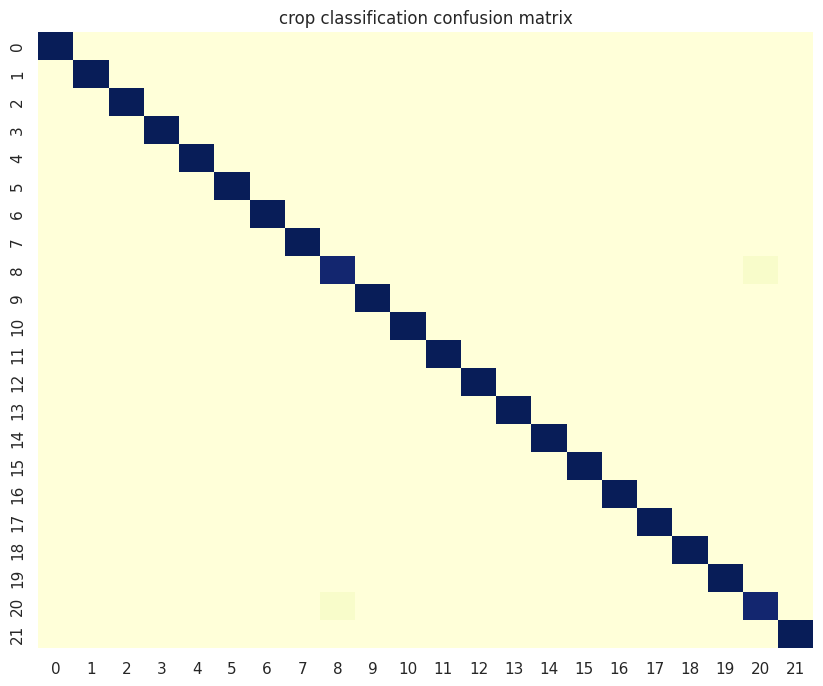

In [41]:
# confusion matrix
conf_matrix = confusion_matrix(
    y_test,
    rf_pred
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    cmap = "YlGnBu",
    cbar = False
)
plt.title("crop classification confusion matrix")
plt.show()

### xgboost

In [46]:
# model initialization
xgb_clf = XGBClassifier(
    n_estimators = 500,
    learning_rate = 0.05,
    max_depth = 0,
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 21,
    eval_metric = "mlogloss"
)

In [47]:
# training the model
xgb_clf.fit(
    X_train_scaled,
    y_train
)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [48]:
# predictions
xgb_pred = xgb_clf.predict(X_test_scaled)

In [49]:
# evaluation
acc = accuracy_score(
    y_test, xgb_pred
)
xgb_clf_report = classification_report(
    y_test,
    xgb_pred,
    target_names = encoder.classes_
)
print(f"xgboost classifier accuracy: {acc:.3f}")
print("xgboost classifier classification report:\n", xgb_clf_report)

xgboost classifier accuracy: 0.993
xgboost classifier classification report:
               precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      0.95      0.95        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.95      0.97        20
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.95      1.00      0.98        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
   

In [50]:
# cross validation
cv_scores = cross_val_score(
    xgb_clf,
    X_train_scaled,
    y_train,
    cv = 5
)
print("cross validation mean:", np.mean(cv_scores))

cross validation mean: 0.9954545454545454


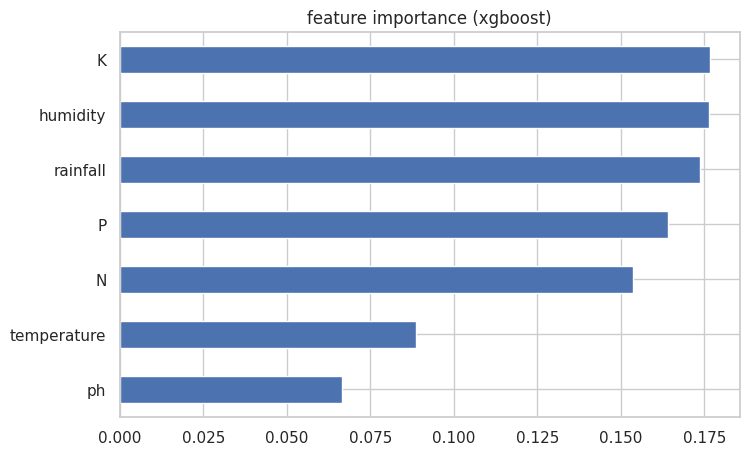

In [51]:
# feature importance
importances = pd.Series(
    xgb_clf.feature_importances_,
    index = X.columns
)
importances.sort_values().plot(
    kind = "barh",
    figsize = (8, 5)
)
plt.title("feature importance (xgboost)")
plt.show()

## SHAP model explainability